In [1]:
import matplotlib.pyplot as plt
import numpy as np
import utils
import network_layers
import tensorflow as tf
from keras import layers, Model

In [3]:
#set the necessary seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import datasets

### Breast cancer dataset

In [4]:
train_pairs_breast, val_pairs_breast, test_pairs_breast = utils.split_dataset(utils.create_list())
print(f"Number of training pairs: {len(train_pairs_breast)}")
print(f"Number of val pairs: {len(val_pairs_breast)}")
print(f"Number of test_pairs pairs: {len(test_pairs_breast)}")

Number of training pairs: 388
Number of val pairs: 129
Number of test_pairs pairs: 130


In [5]:
train_dataset_breast = utils.create_dataset(train_pairs_breast, augment=True)
val_dataset_breast = utils.create_dataset(val_pairs_breast)
test_dataset_breast = utils.create_dataset(test_pairs_breast)

In [4]:
batch_size = 8

In [7]:
#batch the dataset and shuffle the training set

train_dataset_breast = train_dataset_breast.shuffle(buffer_size=len(train_pairs_breast)).batch(batch_size)
val_dataset_breast = val_dataset_breast.batch(batch_size)
test_dataset_breast = test_dataset_breast.batch(batch_size)

### Skin cancer dataset

In [4]:
train_dataset_skin = utils.create_dataset(utils.create_list_skin("Datasets/ISIC-2017_Training_Data", "Datasets/ISIC-2017_Training_Part1_GroundTruth"), augment=True)
val_dataset_skin = utils.create_dataset(utils.create_list_skin("Datasets/ISIC-2017_Validation_Data", "Datasets/ISIC-2017_Validation_Part1_GroundTruth"))
test_dataset_skin =utils. create_dataset(utils.create_list_skin("Datasets/ISIC-2017_Test_v2_Data", "Datasets/ISIC-2017_Test_v2_Part1_GroundTruth"))

In [7]:
train_dataset_skin = train_dataset_skin.shuffle(buffer_size=2000).batch(batch_size)
val_dataset_skin = val_dataset_skin.batch(batch_size)
test_dataset_skin = test_dataset_skin.batch(batch_size)

### Brain cancer dataset

In [5]:
train_pairs_brain, val_pairs_brain, test_pairs_brain = utils.split_dataset(utils.create_list_brain())
print(f"Number of training pairs: {len(train_pairs_brain)}")
print(f"Number of val pairs: {len(val_pairs_brain)}")
print(f"Number of test_pairs pairs: {len(test_pairs_brain)}")

Number of training pairs: 1838
Number of val pairs: 613
Number of test_pairs pairs: 613


In [6]:
train_dataset_brain = utils.create_dataset(train_pairs_brain, augment=True)
val_dataset_brain = utils.create_dataset(val_pairs_brain)
test_dataset_brain = utils.create_dataset(test_pairs_brain)

In [7]:
train_dataset_brain = train_dataset_brain.shuffle(buffer_size=len(train_pairs_brain)).batch(batch_size)
val_dataset_brain = val_dataset_brain.batch(batch_size)
test_dataset_brain = test_dataset_brain.batch(batch_size)

## Architecture definition

In [10]:
def attention_unet(input_shape, num_filters=16):
    inputs = layers.Input(input_shape)

    #encoder block
    first_conv = network_layers.convolutional_layer(inputs, num_filters)
    first_layer = layers.MaxPool2D(pool_size=(2, 2))(first_conv)

    second_conv = network_layers.convolutional_layer(first_layer, num_filters * 2)
    second_layer = layers.MaxPool2D(pool_size=(2, 2))(second_conv)

    third_conv = network_layers.convolutional_layer(second_layer, num_filters * 4)
    third_layer = layers.MaxPool2D(pool_size=(2, 2))(third_conv)

    fourth_conv = network_layers.convolutional_layer(third_layer, num_filters * 8)
    fourth_layer = layers.MaxPool2D(pool_size=(2, 2))(fourth_conv)

    fifth_conv = network_layers.convolutional_layer(fourth_layer, num_filters * 16)

    #decoder block with attention
    first_deconv = layers.UpSampling2D(interpolation="bilinear")(fifth_conv)
    first_att = network_layers.attention_gate(fourth_conv, first_deconv, num_filters * 8)
    sixth_layer = layers.concatenate([first_deconv, first_att])
    sixth_conv = network_layers.convolutional_layer(sixth_layer, num_filters * 8, dropout=True)

    second_deconv = layers.UpSampling2D(interpolation="bilinear")(sixth_conv)
    second_att = network_layers.attention_gate(third_conv, second_deconv, num_filters * 4)
    seventh_layer = layers.concatenate([second_deconv, second_att])
    seventh_conv = network_layers.convolutional_layer(seventh_layer, num_filters * 4, dropout=True)

    third_deconv = layers.UpSampling2D(interpolation="bilinear")(seventh_conv)
    third_att = network_layers.attention_gate(second_conv, third_deconv, num_filters * 2)
    eighth_layer = layers.concatenate([third_deconv, third_att])
    eighth_conv = network_layers.convolutional_layer(eighth_layer, num_filters * 2, dropout=True)

    fourth_deconv = layers.UpSampling2D(interpolation="bilinear")(eighth_conv)
    fourth_att = network_layers.attention_gate(first_conv, fourth_deconv, num_filters)
    ninth_layer = layers.concatenate([fourth_deconv, fourth_att])
    ninth_conv = network_layers.convolutional_layer(ninth_layer, num_filters, dropout=True)

    #output layer
    output = layers.Conv2D(1, kernel_size=(1, 1), activation="sigmoid")(ninth_conv)

    attention_unet = Model(inputs=inputs, outputs=output)

    return attention_unet

In [12]:
attention_unet_model = attention_unet(input_shape=(256, 256, 3))

In [19]:
attention_unet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_103 (Conv2D)         (None, 256, 256, 16)         448       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_88 (Ba  (None, 256, 256, 16)         64        ['conv2d_103[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_88 (Activation)  (None, 256, 256, 16)         0         ['batch_normalization_88

### Fit on the breast cancer dataset

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

dice_scores = []
iou_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []
training_times = []

num_experiments = 5
input_size = (256, 256, 3)

best_dice = 0.0

for i in range(num_experiments):
    print(f"Training experiment {i+1}/{num_experiments}")

    #create and compile U-Net
    attention_unet_model = attention_unet(input_size)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    attention_unet_model.compile(optimizer=optimizer,
                       loss=utils.tversky_loss,
                       metrics=[utils.dice_coefficient, utils.iou, "accuracy", tf.keras.metrics.Precision(name="precision_metric"), tf.keras.metrics.Recall(name="recall_metric")])

    callbacks = [
        EarlyStopping(monitor='val_dice_coefficient', patience=13, restore_best_weights=True, mode='max', verbose=0),
        ReduceLROnPlateau(monitor='val_dice_coefficient', factor=0.1, patience=7, min_lr=1e-6, mode='max', verbose=0)
    ]

    start_time = time.time()

    history = attention_unet_model.fit(train_dataset_breast, validation_data=val_dataset_breast, epochs=200, callbacks=callbacks, verbose=0)

    elapsed_time = time.time() - start_time
    training_times.append(elapsed_time)
    print(f"Training Time for Experiment {i+1}: {elapsed_time:.2f} seconds")

    #select best epoch in terms of dice
    best_epoch_index = np.argmax(history.history['val_dice_coefficient'])

    #get the metrics for that epoch
    final_dice = round(history.history['val_dice_coefficient'][best_epoch_index], 3)
    final_iou = round(history.history['val_iou'][best_epoch_index], 3)
    final_precision = round(history.history['val_precision_metric'][best_epoch_index], 3)
    final_recall = round(history.history['val_recall_metric'][best_epoch_index], 3)
    final_accuracy = round(history.history['val_accuracy'][best_epoch_index], 3)

    #store the results
    dice_scores.append(final_dice)
    iou_scores.append(final_iou)
    precision_scores.append(final_precision)
    recall_scores.append(final_recall)
    accuracy_scores.append(final_accuracy)

    print(f"Dice Coefficient: {final_dice}", f"IoU: {final_iou}", f"Precision: {final_precision}", f"Recall: {final_recall}", f"Accuracy: {final_accuracy}")

    # Save best model based on Dice score
    if final_dice > best_dice:
        best_dice = final_dice
        best_model = attention_unet_model
        attention_unet_model.save("best_attention_unet_breast.h5")
        print(f"New best model saved")

# Compute mean ± std
dice_mean, dice_std = np.mean(dice_scores), np.std(dice_scores)
iou_mean, iou_std = np.mean(iou_scores), np.std(iou_scores)
precision_mean, precision_std = np.mean(precision_scores), np.std(precision_scores)
recall_mean, recall_std = np.mean(recall_scores), np.std(recall_scores)
accuracy_mean, accuracy_std = np.mean(accuracy_scores), np.std(accuracy_scores)
time_mean, time_std = np.mean(training_times), np.std(training_times)

print("Final Results (Across All Runs):")
print(f"Dice Score: {dice_mean:.2f} ± {dice_std:.2f}")
print(f"IoU Score: {iou_mean:.2f} ± {iou_std:.2f}")
print(f"Precision Score: {precision_mean:.2f} ± {precision_std:.2f}")
print(f"Recall Score: {recall_mean:.2f} ± {recall_std:.2f}")
print(f"Accuracy Score: {accuracy_mean:.2f} ± {accuracy_std:.2f}")
print(f"Training Time: {time_mean:.2f} ± {time_std:.2f} seconds")
print(f"Best Model Dice Score: {best_dice:.4f} (Saved as 'best_attention_unet_breast.h5')")

Training experiment 1/5


I0000 00:00:1739213419.789170   50525 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training Time for Experiment 1: 419.85 seconds
Dice Coefficient: 0.643 IoU: 0.479 Precision: 0.657 Recall: 0.65 Accuracy: 0.939


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


New best model saved
Training experiment 2/5
Training Time for Experiment 2: 498.93 seconds
Dice Coefficient: 0.675 IoU: 0.514 Precision: 0.667 Recall: 0.715 Accuracy: 0.943
New best model saved
Training experiment 3/5
Training Time for Experiment 3: 331.40 seconds
Dice Coefficient: 0.609 IoU: 0.444 Precision: 0.62 Recall: 0.639 Accuracy: 0.934
Training experiment 4/5
Training Time for Experiment 4: 603.66 seconds
Dice Coefficient: 0.678 IoU: 0.52 Precision: 0.69 Recall: 0.669 Accuracy: 0.944
New best model saved
Training experiment 5/5
Training Time for Experiment 5: 481.51 seconds
Dice Coefficient: 0.631 IoU: 0.467 Precision: 0.591 Recall: 0.709 Accuracy: 0.931
Final Results (Across All Runs):
Dice Score: 0.65 ± 0.03
IoU Score: 0.48 ± 0.03
Precision Score: 0.64 ± 0.04
Recall Score: 0.68 ± 0.03
Accuracy Score: 0.94 ± 0.01
Training Time: 467.07 ± 90.02 seconds
Best Model Dice Score: 0.6780 (Saved as 'best_attention_unet_breast.h5')


In [14]:
best_attention_unet_breast = tf.keras.models.load_model("best_attention_unet_breast.h5")

In [15]:
test_loss, test_dice, test_iou, test_precision, test_recall, test_accuracy = best_attention_unet_breast.evaluate(test_dataset_breast)

17/17 [==============================] - 3s 137ms/step - loss: 0.4010 - dice_coefficient: 0.6126 - iou: 0.4592 - accuracy: 0.9351 - precision_metric: 0.6525 - recall_metric: 0.5932


1/1 [==============================] - 1s 575ms/step


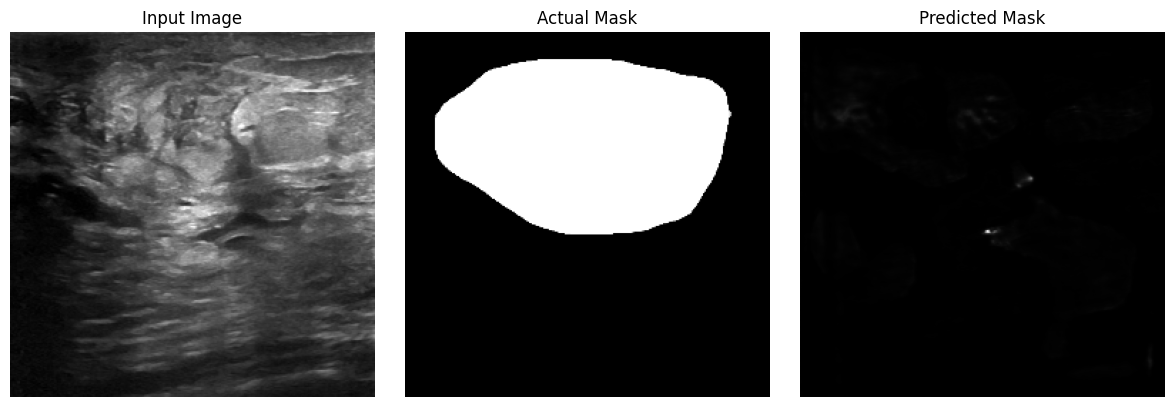

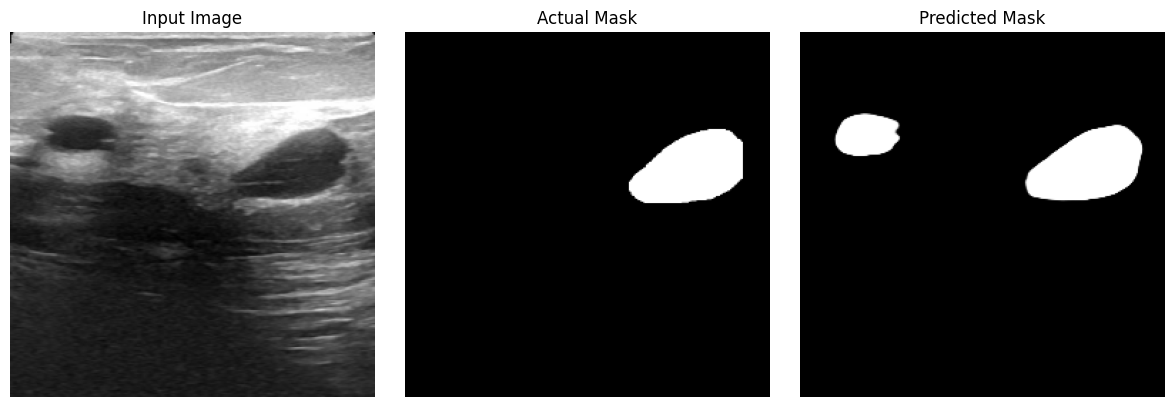

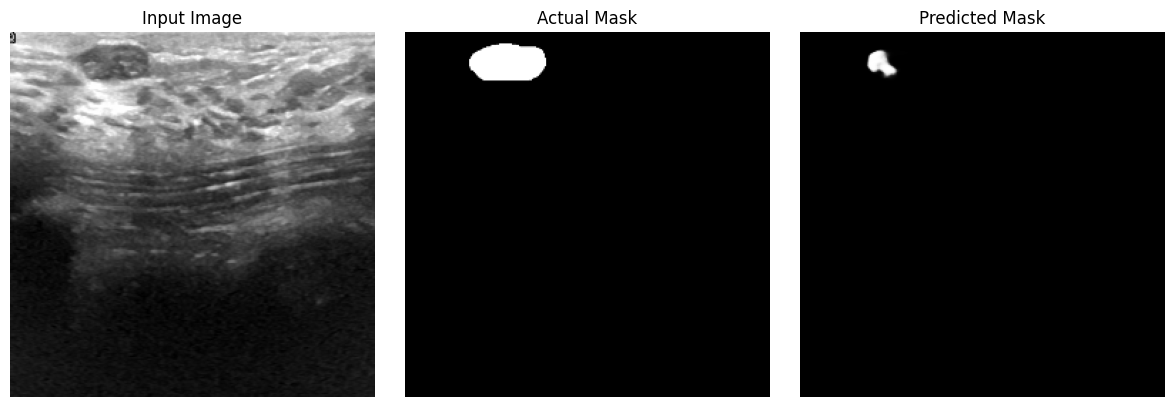

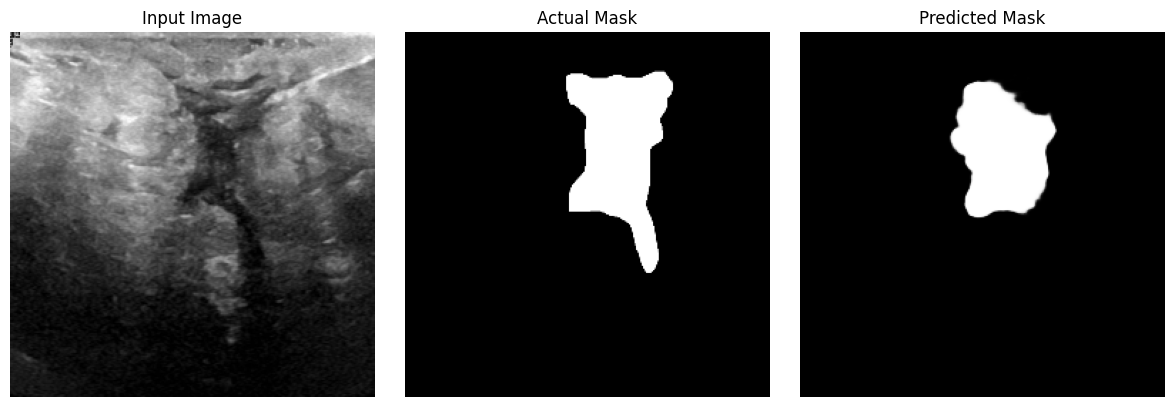

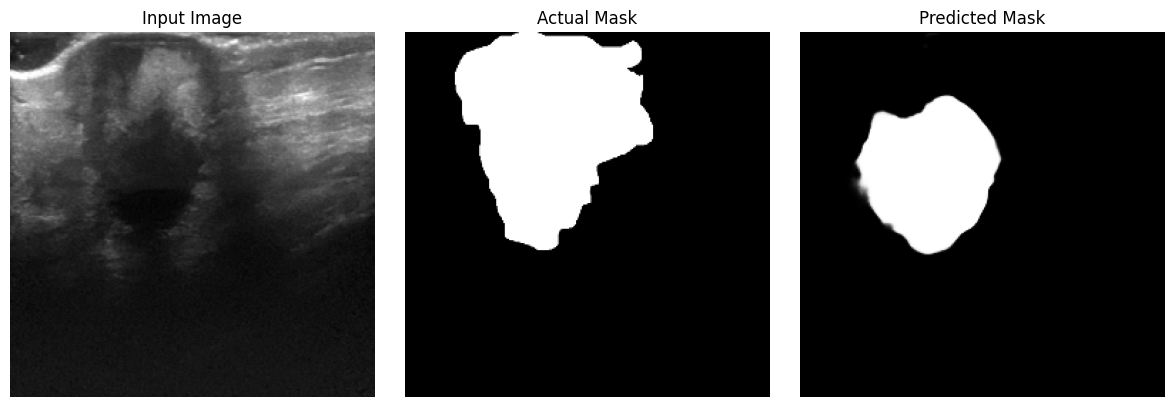

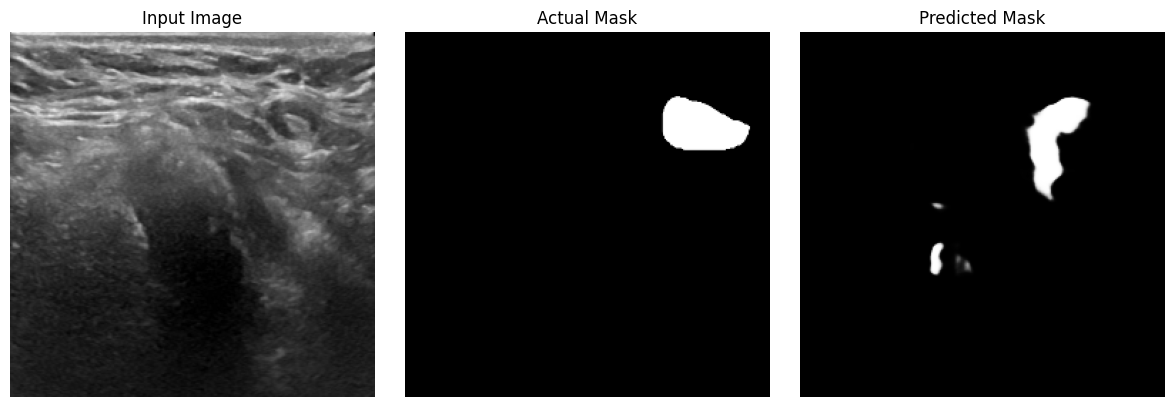

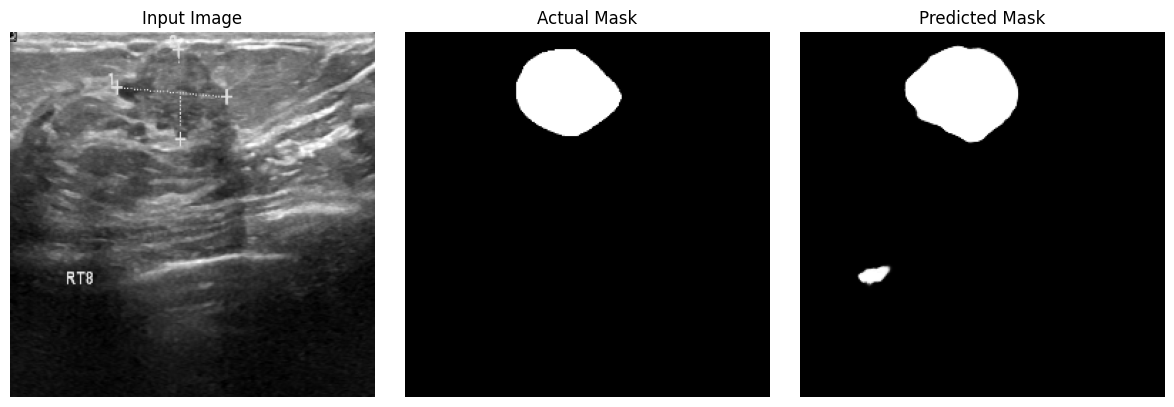

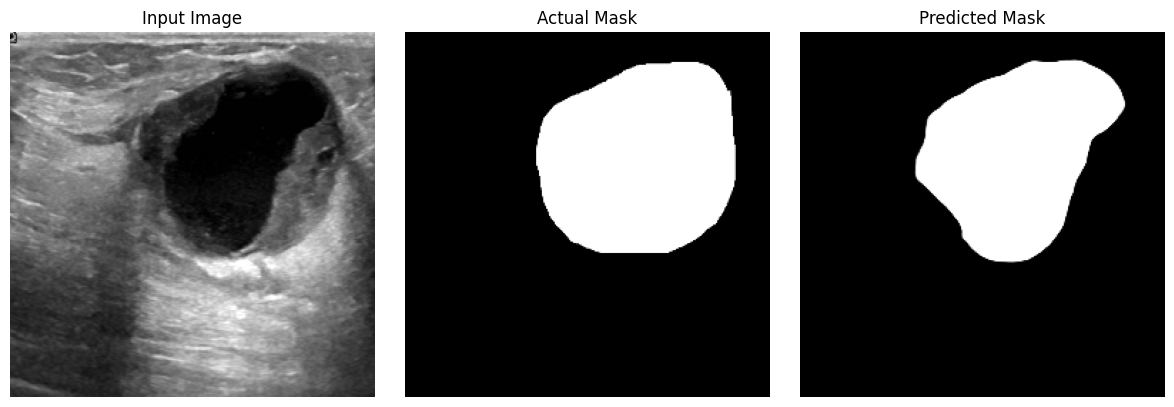

In [16]:
for i, (image, mask) in enumerate(test_dataset_breast.take(1)):
    predicted_mask = best_attention_unet_breast.predict(image)

    for j in range(image.shape[0]):
        plt.figure(figsize=(12, 4))

        #display the input image
        plt.subplot(1, 3, 1)
        plt.imshow(image[j])
        plt.title("Input Image")
        plt.axis('off')

        # Display the actual mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask[j], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[j], cmap='gray')  #
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

### Fit on the skin cancer dataset

In [12]:
dice_scores = []
iou_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []
training_times = []

num_experiments = 5
input_size = (256, 256, 3)

best_dice = 0.0

for i in range(num_experiments):
    print(f"Training experiment {i+1}/{num_experiments}")

    #create and compile U-Net
    attention_unet_model = attention_unet(input_size)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    attention_unet_model.compile(optimizer=optimizer,
                       loss=utils.tversky_loss,
                       metrics=[utils.dice_coefficient, utils.iou, "accuracy", tf.keras.metrics.Precision(name="precision_metric"), tf.keras.metrics.Recall(name="recall_metric")])

    callbacks = [
        EarlyStopping(monitor='val_dice_coefficient', patience=13, restore_best_weights=True, mode='max', verbose=0),
        ReduceLROnPlateau(monitor='val_dice_coefficient', factor=0.1, patience=7, min_lr=1e-6, mode='max', verbose=0)
    ]

    start_time = time.time()

    history = attention_unet_model.fit(train_dataset_skin, validation_data=val_dataset_skin, epochs=200, callbacks=callbacks, verbose=0)

    elapsed_time = time.time() - start_time
    training_times.append(elapsed_time)
    print(f"Training Time for Experiment {i+1}: {elapsed_time:.2f} seconds")

    #select best epoch in terms of dice
    best_epoch_index = np.argmax(history.history['val_dice_coefficient'])

    #get the metrics for that epoch
    final_dice = round(history.history['val_dice_coefficient'][best_epoch_index], 3)
    final_iou = round(history.history['val_iou'][best_epoch_index], 3)
    final_precision = round(history.history['val_precision_metric'][best_epoch_index], 3)
    final_recall = round(history.history['val_recall_metric'][best_epoch_index], 3)
    final_accuracy = round(history.history['val_accuracy'][best_epoch_index], 3)

    #store the results
    dice_scores.append(final_dice)
    iou_scores.append(final_iou)
    precision_scores.append(final_precision)
    recall_scores.append(final_recall)
    accuracy_scores.append(final_accuracy)

    print(f"Dice Coefficient: {final_dice}", f"IoU: {final_iou}", f"Precision: {final_precision}", f"Recall: {final_recall}", f"Accuracy: {final_accuracy}")

    # Save best model based on Dice score
    if final_dice > best_dice:
        best_dice = final_dice
        best_model = attention_unet_model
        attention_unet_model.save("best_attention_unet_skin.h5")
        print(f"New best model saved")

# Compute mean ± std
dice_mean, dice_std = np.mean(dice_scores), np.std(dice_scores)
iou_mean, iou_std = np.mean(iou_scores), np.std(iou_scores)
precision_mean, precision_std = np.mean(precision_scores), np.std(precision_scores)
recall_mean, recall_std = np.mean(recall_scores), np.std(recall_scores)
accuracy_mean, accuracy_std = np.mean(accuracy_scores), np.std(accuracy_scores)
time_mean, time_std = np.mean(training_times), np.std(training_times)

print("Final Results (Across All Runs):")
print(f"Dice Score: {dice_mean:.2f} ± {dice_std:.2f}")
print(f"IoU Score: {iou_mean:.2f} ± {iou_std:.2f}")
print(f"Precision Score: {precision_mean:.2f} ± {precision_std:.2f}")
print(f"Recall Score: {recall_mean:.2f} ± {recall_std:.2f}")
print(f"Accuracy Score: {accuracy_mean:.2f} ± {accuracy_std:.2f}")
print(f"Training Time: {time_mean:.2f} ± {time_std:.2f} seconds")
print(f"Best Model Dice Score: {best_dice:.4f} (Saved as 'best_attention_unet_skin.h5')")

Training experiment 1/5


I0000 00:00:1739256067.299337   82129 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training Time for Experiment 1: 2503.50 seconds
Dice Coefficient: 0.809 IoU: 0.693 Precision: 0.871 Recall: 0.741 Accuracy: 0.936


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


New best model saved
Training experiment 2/5
Training Time for Experiment 2: 2169.49 seconds
Dice Coefficient: 0.804 IoU: 0.683 Precision: 0.825 Recall: 0.794 Accuracy: 0.935
Training experiment 3/5
Training Time for Experiment 3: 3017.40 seconds
Dice Coefficient: 0.808 IoU: 0.688 Precision: 0.835 Recall: 0.791 Accuracy: 0.936
Training experiment 4/5
Training Time for Experiment 4: 2475.49 seconds
Dice Coefficient: 0.794 IoU: 0.672 Precision: 0.844 Recall: 0.741 Accuracy: 0.931
Training experiment 5/5
Training Time for Experiment 5: 2183.66 seconds
Dice Coefficient: 0.783 IoU: 0.657 Precision: 0.813 Recall: 0.758 Accuracy: 0.928
Final Results (Across All Runs):
Dice Score: 0.80 ± 0.01
IoU Score: 0.68 ± 0.01
Precision Score: 0.84 ± 0.02
Recall Score: 0.77 ± 0.02
Accuracy Score: 0.93 ± 0.00
Training Time: 2469.91 ± 307.60 seconds
Best Model Dice Score: 0.8090 (Saved as 'best_attention_unet_skin.h5')


In [13]:
best_attention_unet_skin = tf.keras.models.load_model("Best_models/best_attention_unet_skin.h5")

In [15]:
test_loss, test_dice, test_iou, test_precision, test_recall, test_accuracy = best_attention_unet_skin.evaluate(test_dataset_skin)

75/75 [==============================] - 32s 413ms/step - loss: 0.2294 - dice_coefficient: 0.7983 - iou: 0.6769 - accuracy: 0.9211 - precision_metric: 0.9115 - recall_metric: 0.7417


1/1 [==============================] - 1s 762ms/step


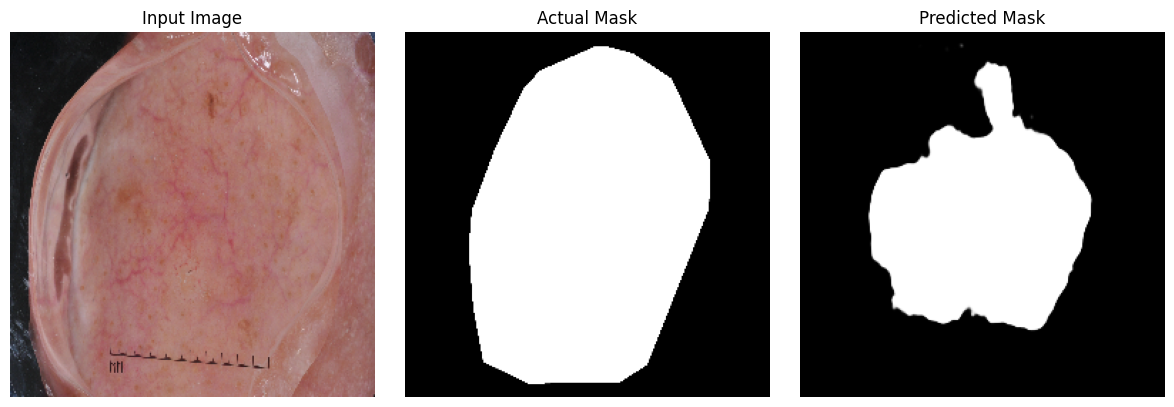

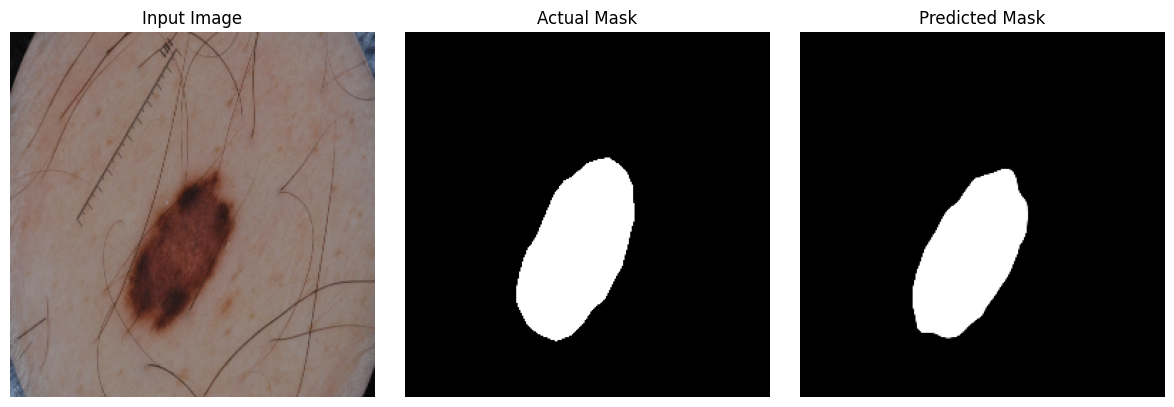

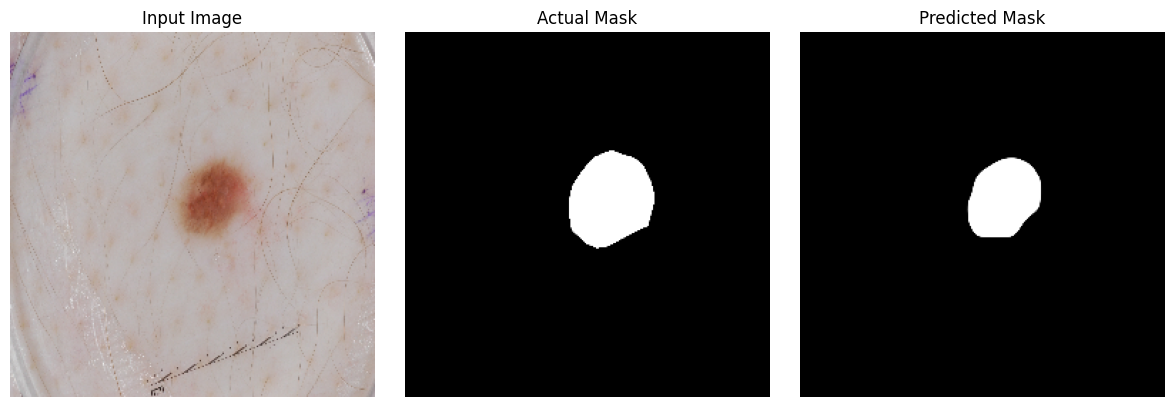

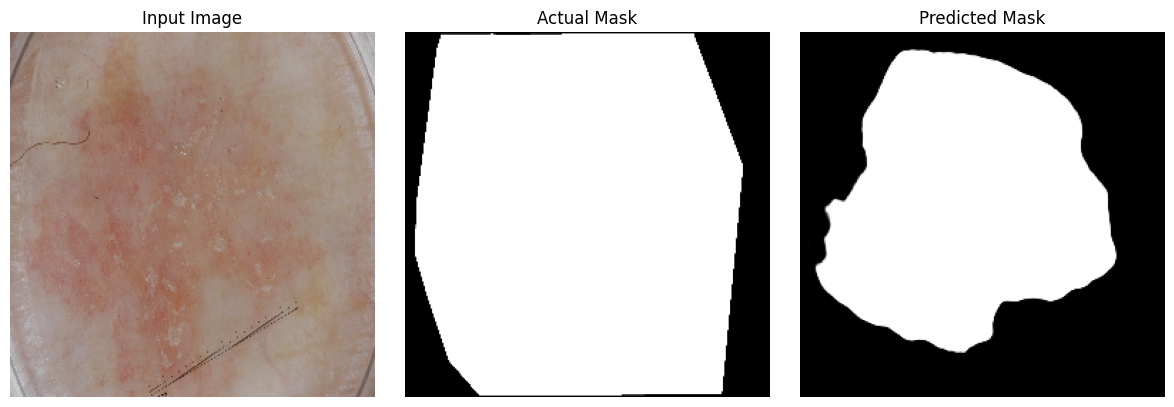

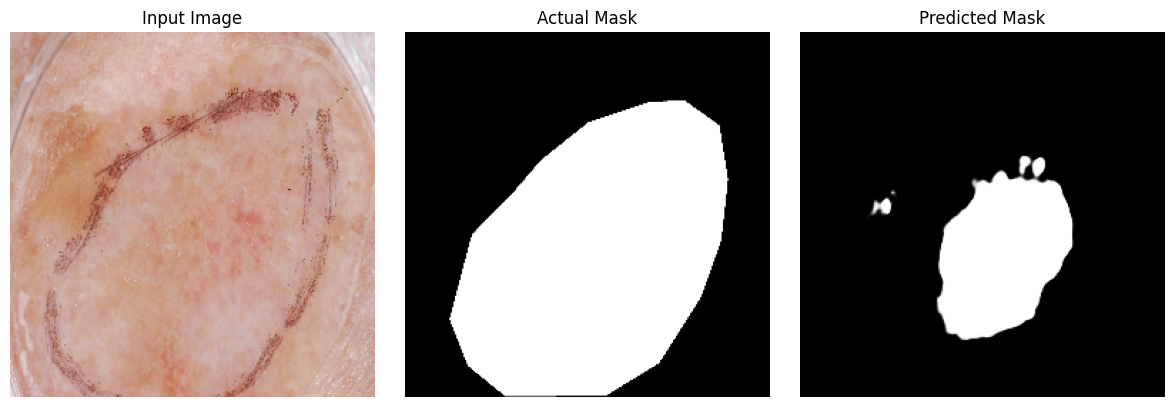

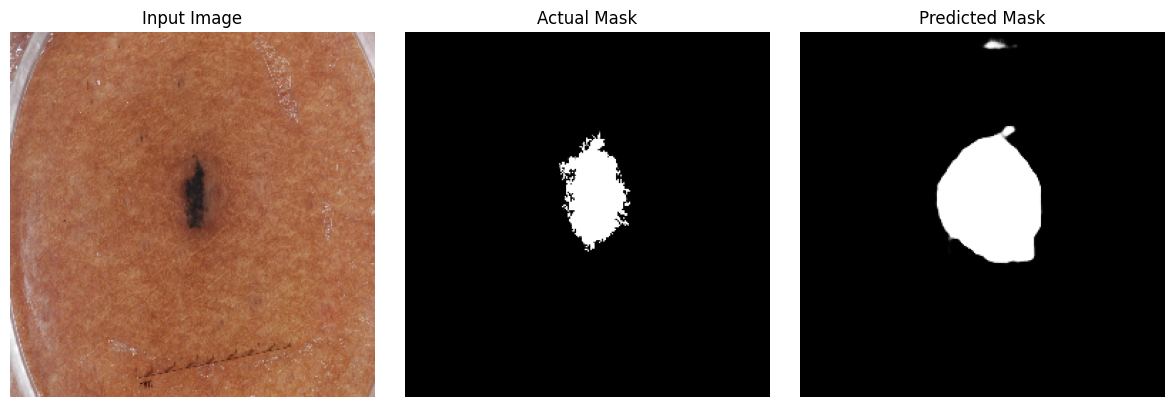

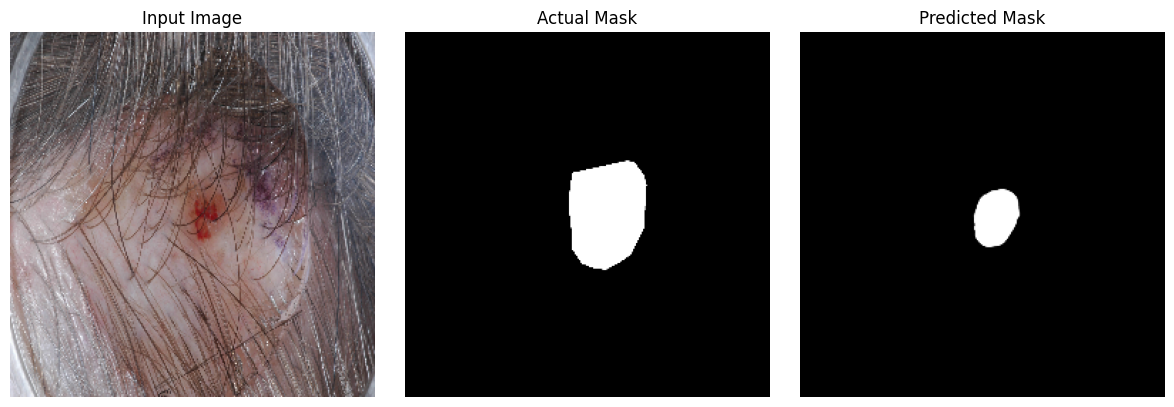

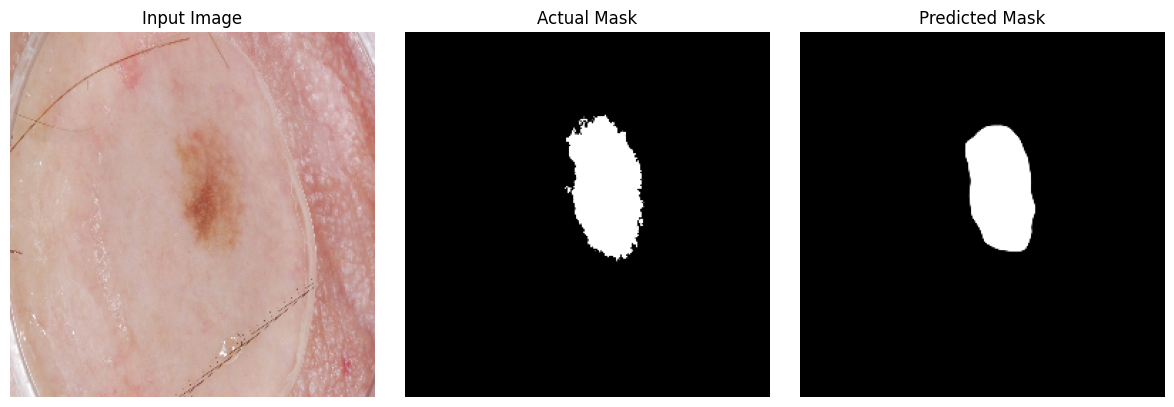

In [16]:
for i, (image, mask) in enumerate(test_dataset_skin.take(1)):
    predicted_mask = best_attention_unet_skin.predict(image)

    for j in range(image.shape[0]):
        plt.figure(figsize=(12, 4))

        #display the input image
        plt.subplot(1, 3, 1)
        plt.imshow(image[j])
        plt.title("Input Image")
        plt.axis('off')

        # Display the actual mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask[j], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[j], cmap='gray')  #
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

### Fit on the brain cancer dataset

In [12]:
dice_scores = []
iou_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []
training_times = []

num_experiments = 5
input_size = (256, 256, 3)

best_dice = 0.0

for i in range(num_experiments):
    print(f"Training experiment {i+1}/{num_experiments}")

    #create and compile U-Net
    attention_unet_model = attention_unet(input_size)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    attention_unet_model.compile(optimizer=optimizer,
                       loss=utils.tversky_loss,
                       metrics=[utils.dice_coefficient, utils.iou, "accuracy", tf.keras.metrics.Precision(name="precision_metric"), tf.keras.metrics.Recall(name="recall_metric")])

    callbacks = [
        EarlyStopping(monitor='val_dice_coefficient', patience=13, restore_best_weights=True, mode='max', verbose=0),
        ReduceLROnPlateau(monitor='val_dice_coefficient', factor=0.1, patience=7, min_lr=1e-6, mode='max', verbose=0)
    ]

    start_time = time.time()

    history = attention_unet_model.fit(train_dataset_brain, validation_data=val_dataset_brain, epochs=200, callbacks=callbacks, verbose=0)

    elapsed_time = time.time() - start_time
    training_times.append(elapsed_time)
    print(f"Training Time for Experiment {i+1}: {elapsed_time:.2f} seconds")

    #select best epoch in terms of dice
    best_epoch_index = np.argmax(history.history['val_dice_coefficient'])

    #get the metrics for that epoch
    final_dice = round(history.history['val_dice_coefficient'][best_epoch_index], 3)
    final_iou = round(history.history['val_iou'][best_epoch_index], 3)
    final_precision = round(history.history['val_precision_metric'][best_epoch_index], 3)
    final_recall = round(history.history['val_recall_metric'][best_epoch_index], 3)
    final_accuracy = round(history.history['val_accuracy'][best_epoch_index], 3)

    #store the results
    dice_scores.append(final_dice)
    iou_scores.append(final_iou)
    precision_scores.append(final_precision)
    recall_scores.append(final_recall)
    accuracy_scores.append(final_accuracy)

    print(f"Dice Coefficient: {final_dice}", f"IoU: {final_iou}", f"Precision: {final_precision}", f"Recall: {final_recall}", f"Accuracy: {final_accuracy}")

    # Save best model based on Dice score
    if final_dice > best_dice:
        best_dice = final_dice
        best_model = attention_unet_model
        attention_unet_model.save("best_attention_unet_brain.h5")
        print(f"New best model saved")

# Compute mean ± std
dice_mean, dice_std = np.mean(dice_scores), np.std(dice_scores)
iou_mean, iou_std = np.mean(iou_scores), np.std(iou_scores)
precision_mean, precision_std = np.mean(precision_scores), np.std(precision_scores)
recall_mean, recall_std = np.mean(recall_scores), np.std(recall_scores)
accuracy_mean, accuracy_std = np.mean(accuracy_scores), np.std(accuracy_scores)
time_mean, time_std = np.mean(training_times), np.std(training_times)

print("Final Results (Across All Runs):")
print(f"Dice Score: {dice_mean:.2f} ± {dice_std:.2f}")
print(f"IoU Score: {iou_mean:.2f} ± {iou_std:.2f}")
print(f"Precision Score: {precision_mean:.2f} ± {precision_std:.2f}")
print(f"Recall Score: {recall_mean:.2f} ± {recall_std:.2f}")
print(f"Accuracy Score: {accuracy_mean:.2f} ± {accuracy_std:.2f}")
print(f"Training Time: {time_mean:.2f} ± {time_std:.2f} seconds")
print(f"Best Model Dice Score: {best_dice:.4f} (Saved as 'best_attention_unet_breast.h5')")

Training experiment 1/5


I0000 00:00:1739288233.058549   14273 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training Time for Experiment 1: 2438.43 seconds
Dice Coefficient: 0.755 IoU: 0.613 Precision: 0.785 Recall: 0.725 Accuracy: 0.991


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


New best model saved
Training experiment 2/5
Training Time for Experiment 2: 2188.12 seconds
Dice Coefficient: 0.747 IoU: 0.607 Precision: 0.796 Recall: 0.713 Accuracy: 0.991
Training experiment 3/5
Training Time for Experiment 3: 3649.43 seconds
Dice Coefficient: 0.761 IoU: 0.624 Precision: 0.834 Recall: 0.704 Accuracy: 0.992
New best model saved
Training experiment 4/5
Training Time for Experiment 4: 2101.46 seconds
Dice Coefficient: 0.74 IoU: 0.595 Precision: 0.771 Recall: 0.719 Accuracy: 0.991
Training experiment 5/5
Training Time for Experiment 5: 3834.22 seconds
Dice Coefficient: 0.737 IoU: 0.593 Precision: 0.795 Recall: 0.69 Accuracy: 0.991
Final Results (Across All Runs):
Dice Score: 0.75 ± 0.01
IoU Score: 0.61 ± 0.01
Precision Score: 0.80 ± 0.02
Recall Score: 0.71 ± 0.01
Accuracy Score: 0.99 ± 0.00
Training Time: 2842.33 ± 745.02 seconds
Best Model Dice Score: 0.7610 (Saved as 'best_attention_unet_breast.h5')


In [13]:
best_attention_unet_brain = tf.keras.models.load_model("Best_models/best_attention_unet_brain.h5")

In [14]:
test_loss, test_dice, test_iou, test_precision, test_recall, test_accuracy = best_attention_unet_brain.evaluate(test_dataset_brain)

77/77 [==============================] - 4s 40ms/step - loss: 0.2722 - dice_coefficient: 0.7426 - iou: 0.6032 - accuracy: 0.9914 - precision_metric: 0.8122 - recall_metric: 0.7029


1/1 [==============================] - 1s 773ms/step


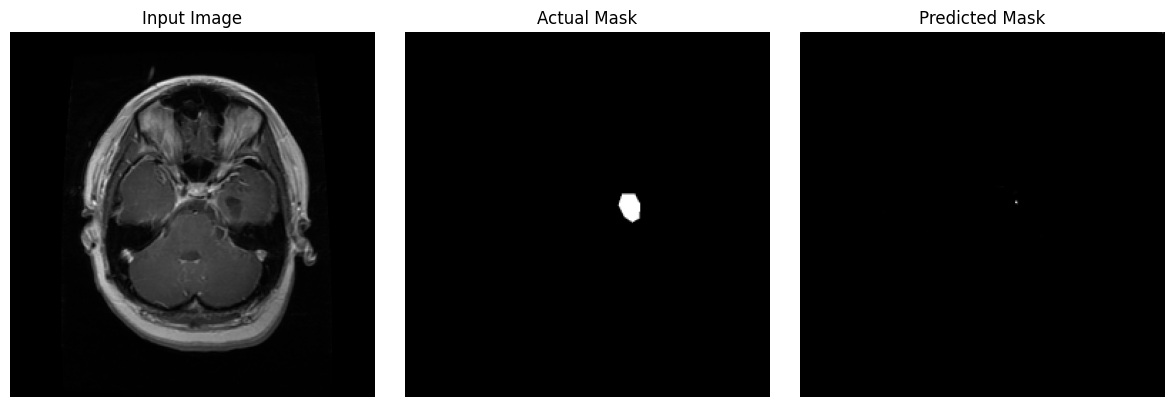

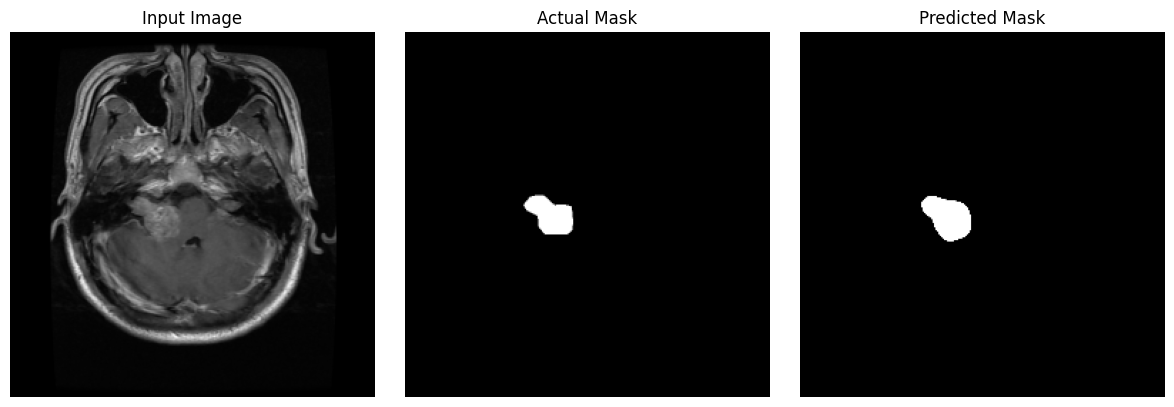

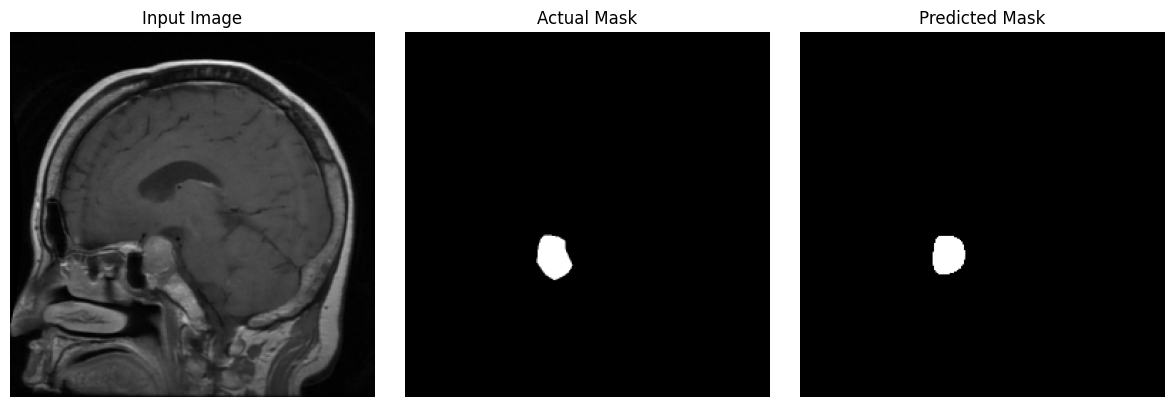

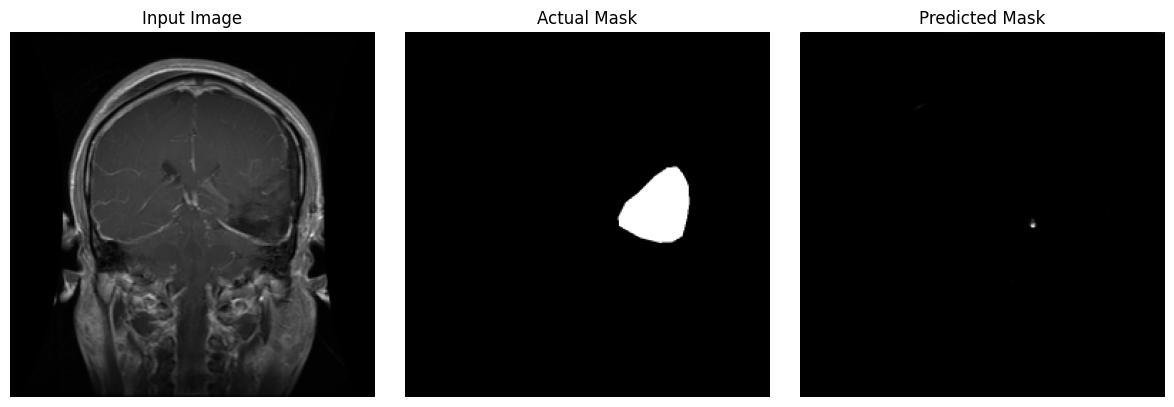

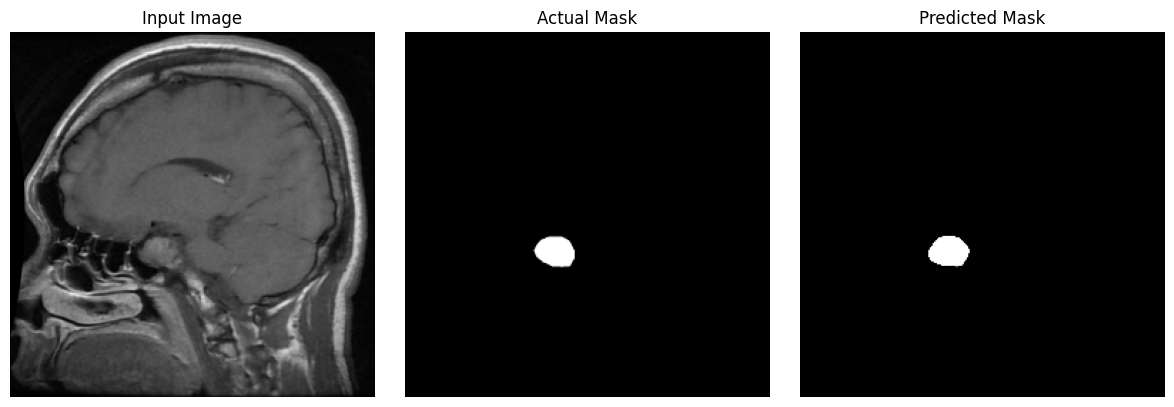

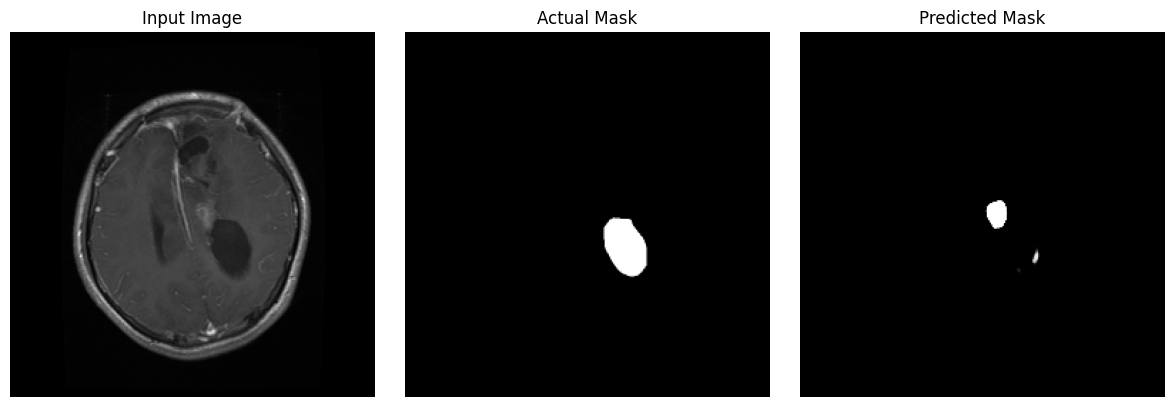

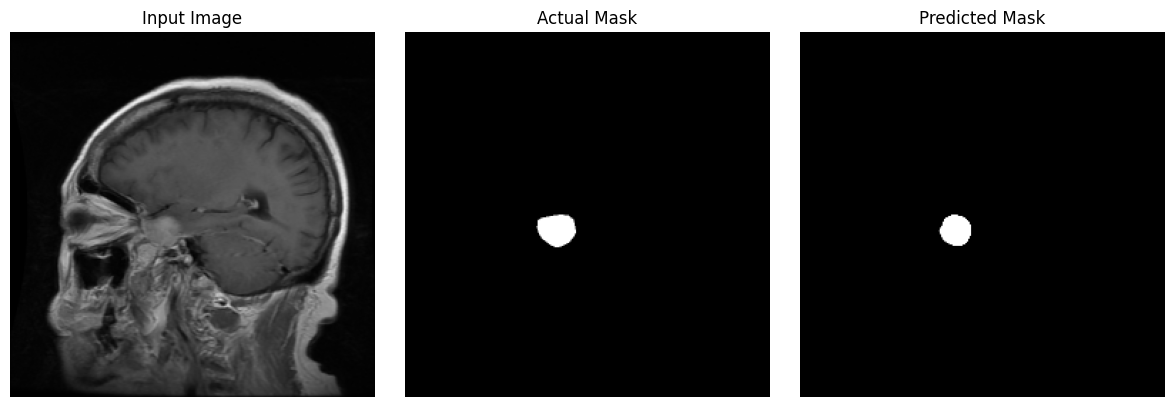

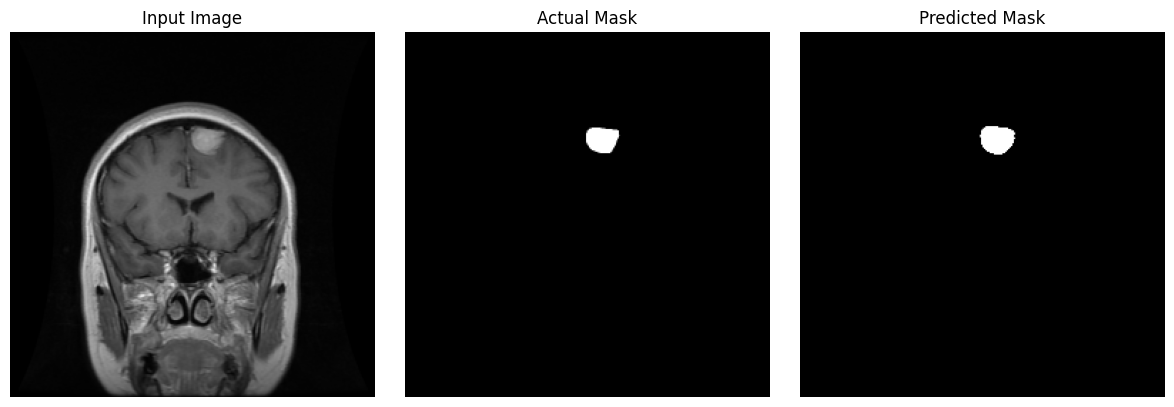

In [15]:
for i, (image, mask) in enumerate(test_dataset_brain.take(1)):
    predicted_mask = best_attention_unet_brain.predict(image)

    for j in range(image.shape[0]):
        plt.figure(figsize=(12, 4))

        #display the input image
        plt.subplot(1, 3, 1)
        plt.imshow(image[j])
        plt.title("Input Image")
        plt.axis('off')

        # Display the actual mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask[j], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[j], cmap='gray')  #
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

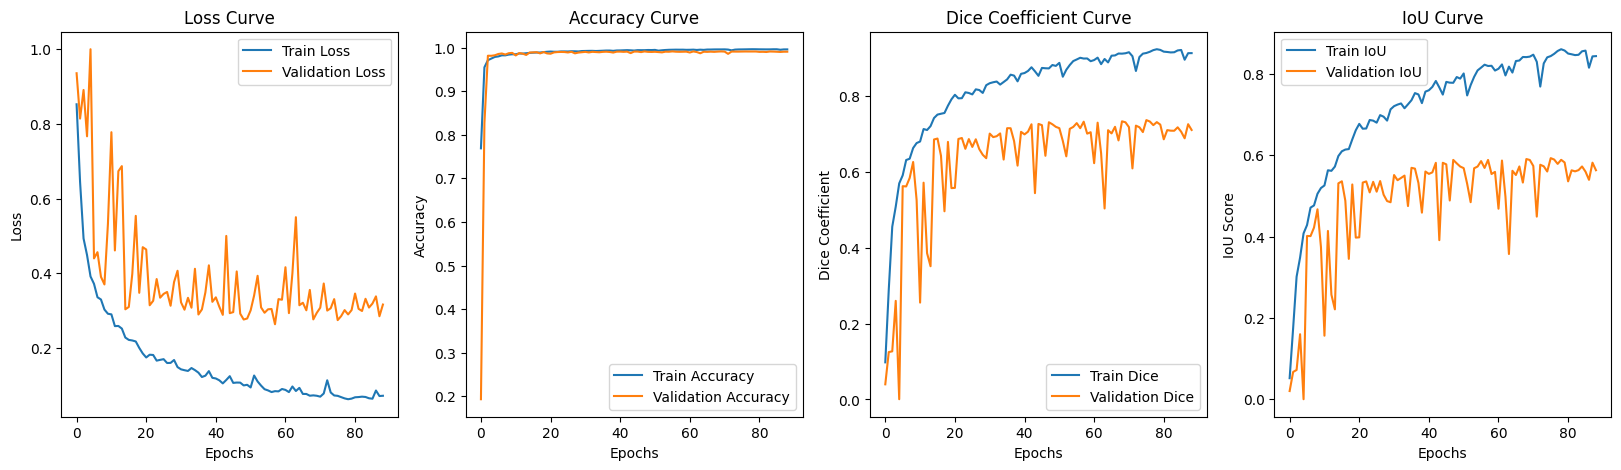

In [16]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Accuracy Curve (if available)
if 'accuracy' in history.history:
    plt.subplot(1, 4, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

plt.subplot(1, 4, 3)
plt.plot(history.history['dice_coefficient'], label='Train Dice')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient Curve')
plt.legend()

# Plot IoU Curve
plt.subplot(1, 4, 4)
plt.plot(history.history['iou'], label='Train IoU')
plt.plot(history.history['val_iou'], label='Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.title('IoU Curve')
plt.legend()

plt.show()